# The Market Making Problem

### Import the necessary libraries

In [128]:
%pip install tensorflow --user

In [2]:
import time
import copy
import random
import sys

import numpy as np
import pandas as pd

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from tqdm.notebook import tqdm 

%matplotlib inline

### Setting up  
#### Setting some global parameters  

Parameters of the reinforcement learning algorithms

In [3]:
EPSILON = 0.5 # Probability for exploration

ALPHA = 0.05 # Step size

GAMMA = 1 # Discount factor for Q-Learning and Sarsa

Some parameters describing the problem and our implementation of it

In [4]:
ACTIONS = [0, 1, 2] # Possible actions

NUM_INV_STEPS = 3 # Number of inventory states: long, short, flat

NUM_PROB_STEPS = 10 # Number of discrete probabilities

# Dimensions of the action-state value array:
Q_DIMS = (NUM_INV_STEPS, NUM_PROB_STEPS, len(ACTIONS))
#Q_DIMS = (NUM_INV_STEPS, NUM_PROB_STEPS, len(ACTIONS))

FILL_PROBS = np.linspace(0, 1, 10) # Possible probability values

c = 0 # Transaction cost

MAX_ITER = float('inf') # Maximum number of iterations in one episode
# (with `MAX_ITER = np.float('inf')`, the entire dataset will be used)

Note the discrete probability values in `FILL_PROBS`. These represent the probability of a bid being fulfilled, and the complement of the probability of an ask being fulfilled.

In [5]:
FILL_PROBS

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

These dictionaries map the names of the actions and positions to their index along the corresponding axis of the state-action value array `q_value` in the learning algorithms

In [6]:
actions = {'buy': 2, 'sell': 0, 'hold': 1} 
positions = {'flat': 0, 'long': 2, 'short': 1}

#### The data generator

The training data are in a .csv file. The data generator object yields the next Limit Order Book update from the file. When it reaches the end of the file, it raises `StopIteration`, and its `rewind()` method must be called to reset it.

In [7]:
class DataFeed(object):
    def __init__(self, data_RA):
        self.data_RA = data_RA
        self.rewind()
    def next(self):
        try:
            return self.__gen.__next__()
        except StopIteration as e:
            raise e
    def rewind(self):
        self.__gen = (row for row in self.data_RA)

In [8]:
t = pd.read_csv('../data/SBER20150310.csv')
t.head()

,Unnamed: 0,BidPrice5,BidVolume5,BidPrice4,BidVolume4,BidPrice3,BidVolume3,BidPrice2,BidVolume2,BidPrice1,...,EMA30,EMA100,STD10,STD50,STD100,STD1000,RSI14,RSI30,RSI50,RSI100
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,70.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,70.00,20.0,70.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,70.0,20.0,70.50,880.0,72.45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,70.0,20.0,70.5,880.0,72.23,10700.0,72.45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,70.0,20.0,70.5,880.0,71.0,100.0,72.23,10700.0,72.45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
data = t[['AskPrice1', 'AskVolume1', 'BidPrice1', 'BidVolume1']]
data.head()

,AskPrice1,AskVolume1,BidPrice1,BidVolume1
0,0.0,0.0,70.00,20.0
1,0.0,0.0,70.50,880.0
2,0.0,0.0,72.45,15000.0
3,0.0,0.0,72.45,15000.0
4,0.0,0.0,72.45,15000.0


In [10]:
data.head(30)

,AskPrice1,AskVolume1,BidPrice1,BidVolume1
0,0.00,0.0,70.00,20.0
1,0.00,0.0,70.50,880.0
2,0.00,0.0,72.45,15000.0
3,0.00,0.0,72.45,15000.0
4,0.00,0.0,72.45,15000.0
5,75.00,700.0,72.45,15000.0
6,75.00,700.0,72.45,15000.0
7,75.00,700.0,72.45,15000.0
8,75.00,700.0,72.45,15000.0
9,75.00,700.0,72.45,15000.0


## Видим, что в данных много дубликатов, что неудивительно из-за частоты данных. Так как нам нужны только апдейты в книге, то удалим дубли

In [11]:
data.drop_duplicates(inplace=True)

<ipython-input-11-515f69ef7765>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(inplace=True)


In [12]:
data.head()

,AskPrice1,AskVolume1,BidPrice1,BidVolume1
0,0.00,0.0,70.00,20.0
1,0.00,0.0,70.50,880.0
2,0.00,0.0,72.45,15000.0
5,75.00,700.0,72.45,15000.0
17,73.93,500.0,72.45,15000.0


In [13]:
np.array(data).shape

(122754, 4)

## Из-за того что были строки с askvolume=0 неправильно считалась gridded сетка probability of ask fill (index in the array of probabilities), поэтому возьмём с момента где aslvolume != 0

In [14]:
data[5:]

,AskPrice1,AskVolume1,BidPrice1,BidVolume1
37,73.90,1000.0,72.45,15000.0
54,73.90,1000.0,72.46,10.0
75,73.25,10000.0,72.46,10.0
90,72.97,150.0,72.46,10.0
204,72.79,10000.0,72.46,10.0
...,...,...,...,...
2114422,69.98,151570.0,69.89,1980.0
2114423,69.97,1270.0,69.89,1980.0
2114425,69.97,3210.0,69.89,1980.0
2114426,69.97,1840.0,69.89,1980.0


In [15]:
#csv_path = '../data/SBER20150310.csv'

#data_RA = np.genfromtxt(csv_path, delimiter=',', dtype=float)
#data_RA = pd.read_csv(csv_path)
data_RA = np.array(data[5:100001])
data_generator = DataFeed(data_RA)

#### State
The state has four elements: 
- position (flat, long, short); 
- probability of ask fill (index in the array of probabilities)
- prices (a dictionary of bid and ask)
- entry price

+

-cash = 1000000 
-bid_depth
-ask_depth
-bid_vol = 100000/bid_price + bid_vol < bid_depth
-ask_vol = 100000/ask_price + ask_vol > ask_depth

We note, however, that the q-value is only a function of the position and probability, and the action taken.

Here, we define a function to "rewind" the data generator to the beginning of the dataset and initialise the state vector

cash_limit_total = 1000000
cash_deal_limit = 100000

def get_initial_state(data_generator):
    data_generator.rewind()
    
    # By convention we start with a flat position
    # and, therefore, no entry price
    position = positions['flat']
    amount_own = 0
    amount_debt = 0
    entry_price = None
    
    ask, ask_depth, bid, bid_depth = data_generator.next()
    
    #price = {'bid': bid/1000.0, 'ask': ask/1000.0}  
    price = {'bid': bid, 'ask': ask}  
    
    # Estimate the fill probability
    q = bid_depth / (bid_depth + ask_depth)
    # Quantise q and scale it to the integer index 
    # q_ind is an index of the vector `FILL_PROBS`
    q_ind = int(q * NUM_PROB_STEPS) 
    
    
    #считаем кол-во которое можно купить/продать на следующей итерации
    bid_vol = cash_deal_limit/price['bid']
    ask_vol = cash_deal_limit/price['ask']
    
    if bid_vol < bid_depth:
        bid_vol = bid_vol
    else:
        bid_vol = bid_depth
        
    if ask_vol < ask_depth:
        ask_vol = ask_vol
    else:
        ask_vol = ask_depth
    
    initial_state = position, q_ind, price, entry_price, bid_depth, ask_depth, bid_vol, ask_vol, cash_limit_total, amount_own, amount_debt
    
    return initial_state

In [ ]:
cash_limit_total = 1000000
cash_deal_limit = 50000

def get_initial_state(data_generator):
    data_generator.rewind()
    
    # By convention we start with a flat position
    # and, therefore, no entry price
    position = positions['flat']
    amount_own = 0
    entry_price = None
    
    ask, ask_depth, bid, bid_depth = data_generator.next()
    
    #price = {'bid': bid/1000.0, 'ask': ask/1000.0}  
    price = {'bid': bid, 'ask': ask}  
    
    # Estimate the fill probability
    q = bid_depth / (bid_depth + ask_depth)
    # Quantise q and scale it to the integer index 
    # q_ind is an index of the vector `FILL_PROBS`
    q_ind = int(q * NUM_PROB_STEPS) 
    
    
    #считаем кол-во которое можно купить/продать на следующей итерации
    bid_vol = cash_deal_limit/price['bid']
    ask_vol = cash_deal_limit/price['ask']
    
    if bid_vol < bid_depth:
        bid_vol = bid_vol
    else:
        bid_vol = bid_depth
        
    if ask_vol < ask_depth:
        ask_vol = ask_vol
    else:
        ask_vol = ask_depth
    
    initial_state = position, q_ind, price, entry_price, bid_depth, ask_depth, bid_vol, ask_vol, cash_limit_total, amount_own
    
    return initial_state

In [ ]:
START = get_initial_state(data_generator)
print(START)

#### Setting up the environment

The step function that describes how the next state is obtained from the current state and the action taken. 

The function returns the next state and the immediate reward obtained from the action taken. 

def step(state, action):
        position, q, price, entry_price, bid_depth, ask_depth, bid_vol, ask_vol, cash_limit_total, amount_own, amount_debt = state
        reward = 0 
        instant_pnl = 0
        done = False
        
        # The ask/bid fill probabilities always sum to 1, meaning
        # that either bid or ask orders can always be executed 
        if FILL_PROBS[q] < np.random.rand():
            fill_bid = True
            fill_ask = False
        else:
            fill_bid = False
            fill_ask = True
        
        # Calculate the result of taking the selected action
        #если агент выставляет заявку на покупку и она исполняется  
        if (action == actions['buy']) and (fill_bid):
            #задаём издержки за сделку
            reward = -c
            #если сейчас позиция "флэт" и исполняется поставленная  заяка на покупку, то 
            if (position == positions['flat']):  
                #меняем позицию на лонг
                position = positions['long']
                #указываем входную цену
                entry_price = price['bid']
                #пересчитываем объём, который агент может купить по новой цене покупки 
                #с учётом лимита на сделку
                #уменьшаем кэш с учётом объёма и цены покупки            
                cash_limit_total -= bid_vol*entry_price
                #увеличиваем число акции которое есть у агента в inventory
                amount_own += bid_vol
            elif(position == positions['short']): # closing out a short position          
                position = positions['flat']
                exit_price =  price['bid']
                #прибыль/убыток от закрытия короткой позиции
                instant_pnl = bid_vol*(entry_price - exit_price)
                entry_price = None
                #кол-во которое агент должен уменьшается на то кол-во которое он купил
                amount_debt -= bid_vol
                #уменьшаем кэш с учётом объёма и цены покупки            
                cash_limit_total -= bid_vol*entry_price                
            elif position == positions['long']:
                #raise ValueError("can't buy already got")
                #предположим, что агент может купить акции, когда в лонге (добавить акции в портфель)
                cash_limit_total -= bid_vol*entry_price
                amount_own += bid_vol
                entry_price = price['bid']
                
        
        elif (action == actions['sell']) and (fill_ask):
            reward = -c
            if (position == positions['flat']):
                position = positions['short']
                entry_price = price['ask']
                cash_limit_total += ask_vol*entry_price
                amount_own -= ask_vol
            elif (position == positions['long']): # closing out a long position   
                exit_price = price['ask']
                position = positions['flat']
                instant_pnl = ask_vol*(exit_price - entry_price)
                entry_price = None
                amount_own -= ask_vol
                cash_limit_total += ask_vol*entry_price  
            elif position == positions['short']:
                #raise ValueError("can't sell already short")
                cash_limit_total += ask_vol*entry_price
                amount_debt += ask_vol
                entry_price = price['ask']

        reward += instant_pnl
        
        try:            
            # Get the next limit order book update
            ask, ask_depth, bid, bid_depth = data_generator.next()
            
            # Calculate the price and bid/ask fill probabilities for the next state
            price = {'bid': bid, 'ask': ask}

            # Estimate the fill probability
            q = bid_depth / (bid_depth + ask_depth)
            
            # Quantise q and scale it to the integer index 
            # q_ind is an index of the vector `FILL_PROBS`
            q_ind = int(q * NUM_PROB_STEPS) 
            
            #считаем кол-во которое можно купить/продать на следующей итерации
            bid_vol = cash_deal_limit/price['bid']
            ask_vol = cash_deal_limit/price['ask']
    
            if bid_vol < bid_depth:
                bid_vol = bid_vol
            else:
                bid_vol = bid_depth
        
            if ask_vol < ask_depth:
                ask_vol = ask_vol
            else:
                ask_vol = ask_depth
            
        except StopIteration as e:
            # This happens when the data generator reaches the end of the dataset
            raise e
        
        next_state = position, q_ind, price, entry_price, bid_depth, ask_depth, bid_vol, ask_vol, cash_limit_total, amount_own, amount_debt
        return next_state, reward

## С одним кол-вом amount_own

In [ ]:
def step(state, action):
        position, q, price, entry_price, bid_depth, ask_depth, bid_vol, ask_vol, cash_limit_total, amount_own = state
        reward = 0 
        instant_pnl = 0
        done = False
        
        # The ask/bid fill probabilities always sum to 1, meaning
        # that either bid or ask orders can always be executed 
        if FILL_PROBS[q] < np.random.rand():
            fill_bid = True
            fill_ask = False
        else:
            fill_bid = False
            fill_ask = True
        
        # Calculate the result of taking the selected action
        #если агент выставляет заявку на покупку и она исполняется  
        if (action == actions['buy']) and (fill_bid):
            #задаём издержки за сделку
            reward = -c
            #если сейчас позиция "флэт" и исполняется поставленная  заяка на покупку, то 
            if (position == positions['flat']):  
                #меняем позицию на лонг
                position = positions['long']
                #указываем входную цену
                entry_price = price['bid']
                #пересчитываем объём, который агент может купить по новой цене покупки 
                #с учётом лимита на сделку
                #уменьшаем кэш с учётом объёма и цены покупки            
                cash_limit_total -= bid_vol*entry_price
                #увеличиваем число акции которое есть у агента в inventory
                amount_own += bid_vol
            elif(position == positions['short']): # closing out a short position          
                position = positions['flat']
                exit_price =  price['bid']
                #прибыль/убыток от закрытия короткой позиции
                instant_pnl = bid_vol*(entry_price - exit_price)
                entry_price = None
                #кол-во которое агент должен уменьшается на то кол-во которое он купил
                #amount_own -= bid_vol
                #уменьшаем кэш с учётом объёма и цены покупки            
                #cash_limit_total -= bid_vol*entry_price                
            elif position == positions['long']:
                #raise ValueError("can't buy already got")
                #предположим, что агент может купить акции, когда в лонге (добавить акции в портфель)
                cash_limit_total -= bid_vol*entry_price
                amount_own += bid_vol
                entry_price = price['bid']
                
        
        elif (action == actions['sell']) and (fill_ask):
            reward = -c
            if (position == positions['flat']):
                position = positions['short']
                entry_price = price['ask']
                cash_limit_total += ask_vol*entry_price
                amount_own -= ask_vol
            elif (position == positions['long']): # closing out a long position   
                exit_price = price['ask']
                position = positions['flat']
                instant_pnl = ask_vol*(exit_price - entry_price)
                entry_price = None
                #amount_own -= ask_vol
                #cash_limit_total += ask_vol*entry_price  
            elif position == positions['short']:
                #raise ValueError("can't sell already short")
                cash_limit_total += ask_vol*entry_price
                amount_own -= ask_vol
                entry_price = price['ask']

        reward += instant_pnl
        
        try:            
            # Get the next limit order book update
            ask, ask_depth, bid, bid_depth = data_generator.next()
            
            # Calculate the price and bid/ask fill probabilities for the next state
            price = {'bid': bid, 'ask': ask}

            # Estimate the fill probability
            q = bid_depth / (bid_depth + ask_depth)
            
            # Quantise q and scale it to the integer index 
            # q_ind is an index of the vector `FILL_PROBS`
            q_ind = int(q * NUM_PROB_STEPS) 
            
            #считаем кол-во которое можно купить/продать на следующей итерации
            bid_vol = cash_deal_limit/price['bid']
            ask_vol = cash_deal_limit/price['ask']
    
            if bid_vol < bid_depth:
                bid_vol = bid_vol
            else:
                bid_vol = bid_depth
        
            if ask_vol < ask_depth:
                ask_vol = ask_vol
            else:
                ask_vol = ask_depth
            
        except StopIteration as e:
            # This happens when the data generator reaches the end of the dataset
            raise e
        
        next_state = position, q_ind, price, entry_price, bid_depth, ask_depth, bid_vol, ask_vol, cash_limit_total, amount_own
        return next_state, reward

In [ ]:
# Check START state, action pairs and the associated reward
print(actions)
state = get_initial_state
print(step(START, 0))
print(step(START, 1))

### Set up the agent's action policy
Given $S_t$ and $Q_t\left( s_t, a_t\right)$, this function chooses an action based on the epsilon-greedy algorithm

def choose_action(state, q_value, eps=EPSILON):
    position, q, price, entry_price = state
    
    # With probability eps we choose randomly among allowed actions
    if np.random.binomial(1, eps) == 1: 
        if position == positions['long']:
            action = np.random.choice([actions['hold'], actions['sell']])
        elif position == positions['short']:
            action = np.random.choice([actions['hold'], actions['buy']])
        else:
            action = np.random.choice([actions['hold'], actions['buy'], actions['sell']])  
        
    # Otherwise the best available action is selected
    else:
        # Make a list of the actions available from the current state
        if position == positions['long']:
            actions_ = [actions['hold'], actions['sell']]        
        elif position == positions['short']:
            actions_ = [actions['hold'], actions['buy']]
        else:
            actions_ = [actions['hold'], actions['buy'], actions['sell']]
        # Get the state-action values for the current state
        values_ = q_value[state[0], state[1], actions_]
        #values_ = q_value[state[0], state[1]-1, actions_]
        # In case of a tie, choose from those with the highest value
        action = np.random.choice([actions_[action_] for action_, value_ in enumerate(values_) 
                                 if value_ == np.max(values_)])
    return action

In [ ]:
def choose_action(state, q_value, eps=EPSILON):
    position, q, price, entry_price, bid_depth, ask_depth, bid_vol, ask_vol, cash_limit_total, amount_own = state
    
    # With probability eps we choose randomly among allowed actions
    if np.random.binomial(1, eps) == 1: 
        #добавим возможность докупать акции, когда уже в лонге
        #аналогично для шорта
        #поэтому фактически остаётся, что агенту доступны все действия вне зависимости от позиции
        action = np.random.choice([actions['hold'], actions['buy'], actions['sell']])  
        
    # Otherwise the best available action is selected
    else:
        # Make a list of the actions available from the current state
        #добавим возможность докупать акции, когда уже в лонге
        #аналогично для шорта
        #поэтому фактически остаётся, что агенту доступны все действия вне зависимости от позиции
        actions_ = [actions['hold'], actions['buy'], actions['sell']]
        # Get the state-action values for the current state
        values_ = q_value[state[0], state[1], actions_]
        #что подаём на q_value?
        
        # In case of a tie, choose from those with the highest value
        action = np.random.choice([actions_[action_] for action_, value_ in enumerate(values_) 
                                 if value_ == np.max(values_)])
    return action

To demonstrate the 

In [ ]:
# Set a random state-action value function
q_value_example = np.random.random(Q_DIMS) 

# Show the initial state
state = get_initial_state(data_generator)
print(state)

# The action values for the initial state. 
# state[0] is the position; state[1] is the bid fill probability
print(q_value_example[state[0], state[1], :])


# With epsilon = 0, the selected action is always that with the highest Q-value
print(choose_action(state, q_value_example, eps=0))

In [ ]:
#q_value_example

### Set up the learning algorithms

#### Sarsa and Expected Sarsa

The function below runs through a learning episode with Sarsa. It takes the state-action value array `q_value` as an argument, initialises the state to `START`, defined above, and updates `q_value` according to the Sarsa algorithm, until reaching either the end of the training data or the maximum number of iterations. The cumulative reward earned is returned.

In [ ]:
def sarsa(q_value, expected=False, step_size=ALPHA, eps=EPSILON):
    
    state = get_initial_state(data_generator)
    
    action = choose_action(state, q_value, eps)
    rewards = 0.0
    done = False
    iteration = 0
    #вернем состояния
    #states=[]
    
    while (iteration < MAX_ITER) and not done:
        # The step function will raise StopIteration when there
        # is no more data available to calculate the next state:
        try:
            next_state, reward = step(state, action)
        except StopIteration:
            # Skip the rest of the loop and end the episode.
            # As there is no new `next_state`, updating
            # q_value again doesn't make sense
            done = True
            continue
            
        next_action = choose_action(next_state, q_value, eps)
        
        rewards += reward
        #вернем состояния
        #states.append(next_state)
        
        if not expected:
            target = q_value[next_state[0], next_state[1], next_action]
        else:
            # Calculate the expected value of new state for expected SARSA
            target = 0.0
            q_next = q_value[next_state[0], next_state[1], :]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS: 
                if action_ in best_actions:
                    target += ((1.0 -  eps) / len(best_actions) 
                               +  eps / len(ACTIONS)) * q_value[next_state[0], next_state[1], action_]
                else:
                    target +=  eps / len(ACTIONS) * q_value[next_state[0], next_state[1], action_]
        target *= GAMMA
        
        # SARSA update
        q_value[state[0], state[1], action] += step_size * (reward
                 + target - q_value[state[0], state[1], action])
        
        state = next_state
        action = next_action
        iteration += 1
    return rewards
    #вернем состояния
    #return rewards, states

#### Q-learning

This function simulates an episode with Q-learning. It takes the state-action value array `q_value` as an argument, initialises the state to `START`, defined above, and updates `q_value` according to the Q-learning algorithm, until the $T$ time steps have passed, or the stocks have all been sold. The cumulative reward earned is returned.

In [ ]:
def q_learning(q_value, step_size=ALPHA, eps=EPSILON):
    
    state = get_initial_state(data_generator)
    
    rewards = 0.0
    done  = False
    iteration = 0
    #вернем состояния
    #states=[]
    
    while (iteration < MAX_ITER) and not done:
        action = choose_action(state, q_value, eps)
        # The step function will raise StopIteration when there
        # is no more data available to calculate the next state:
        try:
            next_state, reward = step(state, action)
        except StopIteration:
            # Skip the rest of the loop and end the episode.
            # As there is no new `next_state`, updating
            # q_value again doesn't make sense
            done = True
            continue
        
        rewards += reward
        #вернем состояния
        #states.append(next_state)
        
        # Q-Learning update
        q_value[state[0], state[1], action] += step_size * (
                reward + GAMMA * np.max(q_value[next_state[0], next_state[1], :]) -
                q_value[state[0], state[1], action])
        
        state = next_state
        iteration +=1
    return rewards
    #вернем состояния
    #return rewards, states

#### Printing the learned policies

This function will allow us to inspect the optimal action learned for each of the possible states

In [ ]:
def print_optimal_policy(q_value):
    
    optimal_policy = np.argmax(q_value, axis=-1)
    print("ask fill prob:", *['%.2f' % q for q in  FILL_PROBS])
    
    for i in range(0, NUM_INV_STEPS):
        
        # positions ={'flat': 0, 'long': 2, 'short':1}
        str_=""
        if (i==0):
            str_ += '         flat     '
        elif(i==1):
            str_ += '        short     '
        else:
            str_ += '         long     '
            
        for j in range(0, NUM_PROB_STEPS): 
            a = np.int(optimal_policy[i,j])
            # actions = {'buy':2, 'sell':0, 'hold': 1}
            if a == 0:
                str_ += 's    '
            elif a ==1:
                str_ += 'h    ' 
            else:
                str_ += 'b    '  
        print(str_)

#### Set up the epsilon decay

We decrease the value of epsilon with each epoch - epsilon must approach zero as the number of episodes increases in order to ensure that the q-value function converges to the optimum

The following figure demonstrates the exponential decay we are going to use.

In [ ]:
%matplotlib inline

eps = 0.5
epis = 150
epoch = 15

plt.plot([eps*((1-eps)**(i//epoch)) for i in range(epis)])
plt.xlabel('Episode')
plt.ylabel('Epsilon');

### Running Sarsa and Q-learning 

In [ ]:
def train(policy, episodes=150):
    if policy == 'sarsa':
        learning_alg = sarsa
    elif policy == 'q-learning':
        learning_alg = q_learning
    else:
        raise ValueError("choose 'sarsa' or 'q-learning'")
    
    epoch_length = 15
    
    # Initialise the rewards vector and state-action values array
    rewards = np.zeros(episodes)
    q_value = np.zeros(Q_DIMS)
    #states = np.zeros(episodes)
    
    print('Training {}...'.format(policy))
    for i in tqdm(range(0, episodes)):
        eps = EPSILON*((1-EPSILON)**(i//epoch_length))
        rewards[i] = learning_alg(q_value, eps=eps)
        #вернем состояния
        #rewards[i], states[i] = learning_alg(q_value, eps=eps)
    return q_value, rewards
    #return q_value, rewards, states

In [ ]:
q_sarsa, rewards_sarsa = train('sarsa')
q_q_learning, rewards_q_learning = train('q-learning')

In [ ]:
print('SARSA')
print_optimal_policy(q_sarsa)
print('Q-learning')
print_optimal_policy(q_q_learning)

In [ ]:
%matplotlib inline
plt.figure(figsize=(13,8))
plt.plot(rewards_q_learning, label='Q-Learning')
plt.plot(rewards_sarsa, label='SARSA')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.legend();

### Animation of the resulting market making strategy

This code below will run through the dataset, taking actions according to the state-action values learned during the training process above. 

You can choose to use either of the strategies learned by SARSA and Q-learning by assigning them to the `view_strategy` variable.

In [30]:
#view_strategy = q_q_learning
view_strategy = q_sarsa

<IPython.core.display.Javascript object>


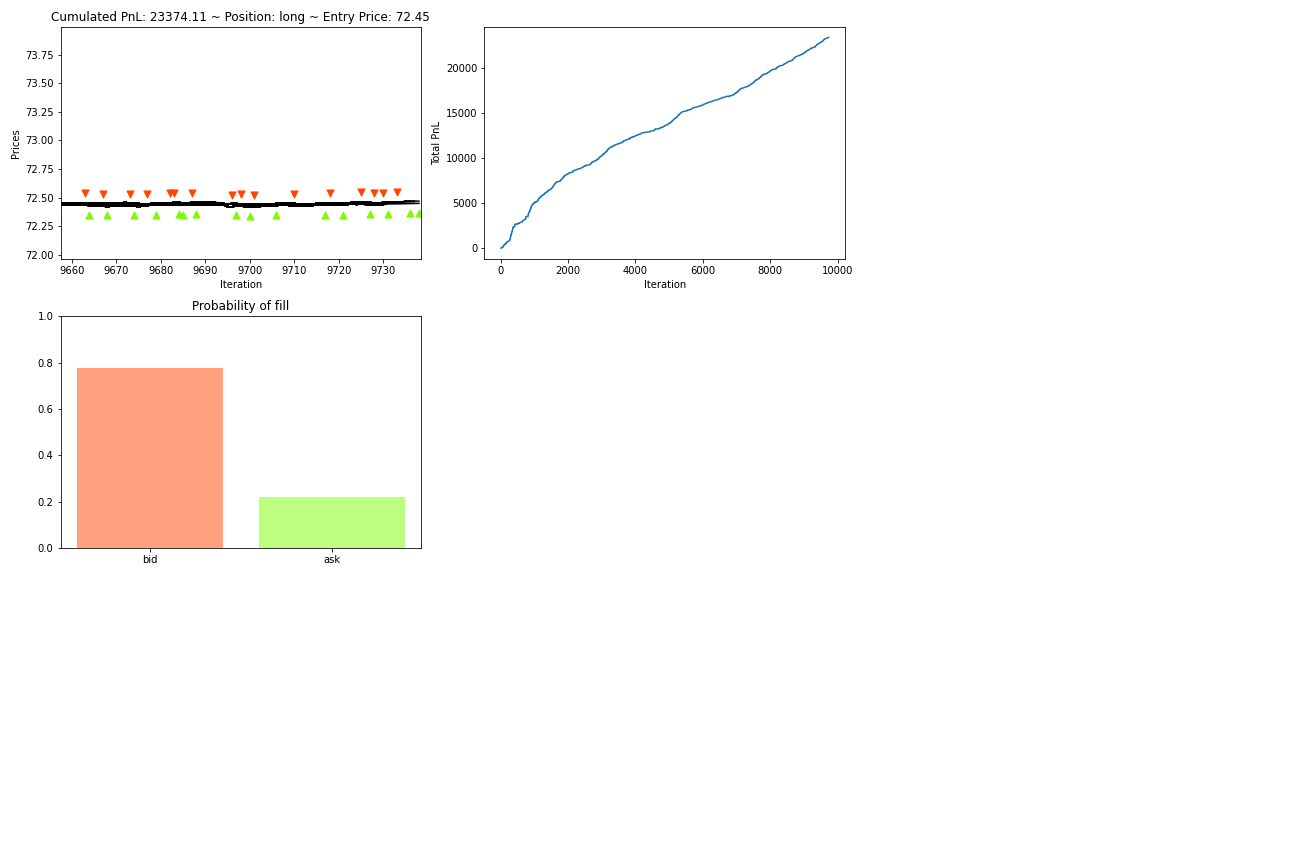

In [ ]:
%matplotlib nbagg
%matplotlib nbagg

fig = plt.figure(figsize=(12, 8))

gs = GridSpec(2,2) # 2 rows, 2 columns

ax1 = fig.add_subplot(gs[0,0]) # First row, first column
ax2 = fig.add_subplot(gs[0,1]) # First row, second column
ax3 = fig.add_subplot(gs[1,0]) # Second row, first column

bids = []
asks = []
bid_fills = []
xdata = []
pnl = []

done = False
state = get_initial_state(data_generator)
rewards = 0.0
iteration = 0

while iteration < MAX_ITER and not done:
    try:
        start_time = time.time()
        prev_position_name = [name for name, pos in positions.items() if pos == state[0]][0] 
        
        action = np.argmax(view_strategy[state[0], state[1]-1, :])
        try:
            state, reward = step(state, action)
        except StopIteration:
            done = True
            print('Stopped at time step', iteration)
            continue
        iteration += 1
        
        position_name = [name for name, pos in positions.items() if pos == state[0]][0] 
        action_name = [name for name, act in actions.items() if act == action][0]                    
        prices = state[2]
        if state[3] is None:
            entry_price = 'n/a'
        else:
            entry_price = "%.2f" % state[3]
        
        # Cumulative PnL
        if len(pnl) == 0:
            pnl.append(reward)
        else: 
            pnl.append(pnl[-1]+reward)

        bids.append(prices['bid'])
        asks.append(prices['ask'])
        xdata.append(iteration)
        
        # Plot most recent 80 prices
        ax1.plot(xdata, 
                 bids, color = 'black')
        ax1.plot(xdata, 
                 asks, color = 'black')
        ax1.set_ylabel('Prices')
        ax1.set_xlabel('Iteration')
        ax1.set_title('Cumulated PnL: ' + "%.2f" % pnl[-1] + ' ~ '
                     + 'Position: ' + position_name + ' ~ '
                     + 'Entry Price: ' + entry_price)
        ax1.set_xlim([max(0, iteration - 80.5), iteration + 0.5])

        # Plotting actions taken according to the Policy
        if position_name != prev_position_name:
            if action == actions['sell']:
                ax1.scatter(iteration, prices['bid']+0.1, 
                        color='orangered', marker='v', s=50)
            elif action == actions['buy']:
                ax1.scatter(iteration, prices['ask']-0.1, 
                        color='lawngreen', marker='^', s=50)
        
        # Ploting PnL
        ax2.clear()
        ax2.plot(xdata, pnl)
        ax2.set_ylabel('Total PnL')
        ax2.set_xlabel('Iteration')

        # Plotting current probabilities to fill
        q_a = FILL_PROBS[state[1]-1]
        q_b = 1 - q_a
        performance = [q_b, q_a]

        ax3.clear()
        ax3.bar([0, 1], [q_b, q_a], align='center', alpha=0.5, 
                color=['orangered','lawngreen'])
        ax3.set_xticks([0, 1])
        ax3.set_xticklabels(['bid', 'ask'])
        ax3.set_title('Probability of fill')
        ax3.set_ylim([0, 1])
        fig.tight_layout()
        fig.canvas.draw()
        time.sleep(max(0, 0.5 - (time.time() - start_time)))
        
    except KeyboardInterrupt:
        print('Animation stopped')
        break

## Попробуем написать класс для среды

## Классы-образцы

In [16]:
class Env(object):
    """Abstract class for an environment. Simplified OpenAI API.
    """

    def __init__(self):
        self.n_actions = None
        self.state_shape = None

    def step(self, action):
        """Run one timestep of the environment's dynamics.
        Accepts an action and returns a tuple (observation, reward, done, info).
        Args:
            action (numpy.array): action array
        Returns:
            tuple:
                - observation (numpy.array): Agent's observation of the current environment.
                - reward (float) : Amount of reward returned after previous action.
                - done (bool): Whether the episode has ended, in which case further step() calls will return undefined results.
                - info (str): Contains auxiliary diagnostic information (helpful for debugging, and sometimes learning).
        """
        raise NotImplementedError()

    def reset(self):
        """Reset the state of the environment and returns an initial observation.
        Returns:
            numpy.array: The initial observation of the space. Initial reward is assumed to be 0.
        """
        raise NotImplementedError()

    def render(self):
        """Render the environment.
        """
        raise NotImplementedError()

## Моя среда

## Надо убрать ограничение на глубину в лобе, потому что есть ещё маркет заявки + неправильно вообще логика была по этому ограничению, т.к. 1) ставишь в одно время, а она исполняется (или нет) позже, скорее всего; 2) с другой стороны - то есть если заявка на покупку исполняется, то это значит, что кто-то согласился продать по твоей цене покупки - и это вообще не связано с тем, что было прописано по органичениям в коде!!!

## Или оставить... иначе нельзя будет сделать бектест, так хотя бы можно посмотреть исполнилась ли в реале заявка или нет

## Добавить методы render и handle_close для отрисовки среды

## Вариант №1 для ограничения кэша: эпизод заканчивается, когда агент тратит все деньги (с помощью этого варика можно увидеть, какой из алгоритмов больший "транжира")

In [1]:
class SpreadTrading(Env):
    """Class for a discrete (buy/hold/sell) spread trading environment.
    """

    _actions = {'buy': 2, 'sell': 0, 'hold': 1} 

    _positions = {'flat': 0, 'long': 2, 'short': 1}

    def __init__(self, data_generator=data_generator, EPSILON = 0.5, ALPHA = 0.05, GAMMA = 1, ACTIONS = [0, 1, 2], NUM_INV_STEPS = 3, NUM_PROB_STEPS = 10, Q_DIMS = (NUM_INV_STEPS, NUM_PROB_STEPS, len(ACTIONS)), FILL_PROBS = np.linspace(0, 1, 10), 
c = 0, MAX_ITER = float('inf'), cash_limit_total = 1000000, cash_deal_limit = 50000, history_length=2, amount_own = 0):
        """Initialisation function
        Args:
            data_generator (tgym.core.DataGenerator): A data
                generator object yielding an array of bid-ask prices and volumes!!!.
            spread_coefficients (list): A list of signed integers defining
                how much of each product to buy (positive) or sell (negative)
                when buying or selling the spread.
            episode_length (int): number of steps to play the game for
            trading_fee (float): penalty for trading
            time_fee (float): time fee
            depths_history: bid, ask depth
            history_length (int): number of historical states to stack in the
                observation vector.
        """
        self._data_generator = data_generator
        self._EPSILON = EPSILON
        self._c = c
        self._ALPHA = ALPHA
        self._GAMMA = GAMMA
        #не уверена, что нужно ещё здесь прописывать actions потому что выше уже указала - ???
        self._ACTIONS = ACTIONS
        self._NUM_INV_STEPS = NUM_INV_STEPS
        self._NUM_PROB_STEPS = NUM_PROB_STEPS
        self._Q_DIMS = Q_DIMS
        self._FILL_PROBS = FILL_PROBS
        self._MAX_ITER = MAX_ITER
        self._cash_limit_total = cash_limit_total
        self._cash_deal_limit = cash_deal_limit
        self._amount_own = amount_own
        
        #доп селфы с оригинального класса - пока не знаю зачем они
        self._first_render = True
        #self._history_length = history_length
        #self._prices_history = []
        #self._depths_history = []
        self.n_actions = 3
        self.reset()
              
    ##перенесём пока в reset всё из функции get_initial_state, потому что мне кажется, что это одно и то же)
    def reset(self):
        """Reset the trading environment. Reset rewards, data generator...
        Returns:
            initial state (tuple): initial state
        """
        self._iteration = 0
        self._data_generator.rewind()
        self._total_reward = 0
        self._total_pnl = 0
        self._position = self._positions['flat']
        self._entry_price = None
        self._cash_limit_total = 1000000
        #наверное, exit price нужно поставить ту что запомнил
        self._exit_price = None
        self._closed_plot = False
        self._amount_own = 0
        
        self._ask, self._ask_depth, self._bid, self._bid_depth = self._data_generator.next()
        self._price = {'bid': self._bid, 'ask': self._ask}
        
        self._q = self._bid_depth / (self._bid_depth + self._ask_depth)
        self._q_ind = int(self._q * self._NUM_PROB_STEPS)

        self._bid_vol = self._cash_deal_limit/self._price['bid']
        self._ask_vol = self._cash_deal_limit/self._price['ask']
        
        #агент должен действовать в рамках лоба, иначе, наверное, нельзя будет сделать бектест
        if self._bid_vol < self._bid_depth:
            self._bid_vol = self._bid_vol
        else:
            self._bid_vol = self._bid_depth
        
        if self._ask_vol < self._ask_depth:
            self._ask_vol = self._ask_vol
        else:
            self._ask_vol = self._ask_depth
    
        initial_state = self._position, self._q_ind, self._price, self._entry_price, self._bid_depth, self._ask_depth, self._bid_vol, self._ask_vol, self._cash_limit_total, self._amount_own
    
        return initial_state
      
    
    def step(self, action):
        
        done = False
        
        self._iteration += 1
        instant_pnl = 0
        reward = 0 
        #done = False
        
        # The ask/bid fill probabilities always sum to 1, meaning
        # that either bid or ask orders can always be executed
        if self._FILL_PROBS[self._q_ind] < np.random.rand():
            fill_bid = True
            fill_ask = False
        else:
            fill_bid = False
            fill_ask = True
        
        # Calculate the result of taking the selected action
        #если агент выставляет заявку на покупку и она исполняется  
        if (action == self._actions['buy']) and (fill_bid):
            #задаём издержки за сделку
            reward = -self._c
            #если сейчас позиция "флэт" и исполняется поставленная  заяка на покупку, то 
            if (self._position == self._positions['flat']):  
                #меняем позицию на лонг
                self._position = self._positions['long']
                #указываем входную цену
                self._entry_price = self._price['bid']
                #пересчитываем объём, который агент может купить по новой цене покупки 
                #с учётом лимита на сделку
                #уменьшаем кэш с учётом объёма и цены покупки            
                self._cash_limit_total -= self._bid_vol*self._entry_price
                #увеличиваем число акции которое есть у агента в inventory
                self._amount_own += self._bid_vol
            elif(self._position == self._positions['short']): # closing out a short position          
                self._position = self._positions['flat']
                self._exit_price =  self._price['bid']
                #прибыль/убыток от закрытия короткой позиции
                instant_pnl = self._bid_vol*(self._entry_price - self._exit_price)
                self._entry_price = None
                #кол-во которое агент должен уменьшается на то кол-во которое он купил
                #amount_own -= bid_vol
                #уменьшаем кэш с учётом объёма и цены покупки            
                #cash_limit_total -= bid_vol*entry_price                
            elif (self._position == self._positions['long']):
                raise ValueError("can't buy already got")
                #предположим, что агент может поставить заявку на покупу, когда в лонге (хочет добавить акции в портфель)
                #self._cash_limit_total -= self._bid_vol*self._entry_price
                #self._amount_own += self._bid_vol
                #self._entry_price = self._price['bid']
                
        
        elif (action == self._actions['sell']) and (fill_ask):
            reward = -self._c
            if (self._position == self._positions['flat']):
                self._position = self._positions['short']
                self._entry_price = self._price['ask']
                self._cash_limit_total += self._ask_vol*self._entry_price
                self._amount_own -= self._ask_vol
            elif (self._position == self._positions['long']): # closing out a long position   
                self._exit_price = self._price['ask']
                self._position = self._positions['flat']
                instant_pnl = self._ask_vol*(self._exit_price - self._entry_price)
                self._entry_price = None
            elif (self._position == self._positions['short']):
                raise ValueError("can't sell already short")
                #self._cash_limit_total += self._ask_vol*self._entry_price
                #self._amount_own -= self._ask_vol
                #self._entry_price = self._price['ask']

        reward += instant_pnl
        self._total_pnl += instant_pnl
        self._total_reward += reward
        
        
        try:            
            # Get the next limit order book update
            self._ask, self._ask_depth, self._bid, self._bid_depth = self._data_generator.next()
            
            # Calculate the price and bid/ask fill probabilities for the next state
            self._price = {'bid': self._bid, 'ask': self._ask}

            # Estimate the fill probability
            self._q = self._bid_depth / (self._bid_depth + self._ask_depth)
            
            # Quantise q and scale it to the integer index 
            # q_ind is an index of the vector `FILL_PROBS`
            self._q_ind = int(self._q * self._NUM_PROB_STEPS) 
            
            #считаем кол-во которое можно купить/продать на следующей итерации
            self._bid_vol = self._cash_deal_limit/self._price['bid']
            self._ask_vol = self._cash_deal_limit/self._price['ask']
    
            if self._bid_vol < self._bid_depth:
                self._bid_vol = self._bid_vol
            else:
                self._bid_vol = self._bid_depth
        
            if self._ask_vol < self._ask_depth:
                self._ask_vol = self._ask_vol
            else:
                self._ask_vol = self._ask_depth
            
        except StopIteration as e:
            # This happens when the data generator reaches the end of the dataset
            #raise e
            #return e
            #print('Data finished')
            done = True

        try:
            assert self._cash_limit_total >= 0
        except AssertionError:
            print(self._cash_limit_total)
            done = True
            #continue
        #если кэша нет, то и торговли нет
        #assert self._cash_limit_total >= 0
        
        next_state = self._position, self._q_ind, self._price, self._entry_price, self._bid_depth, self._ask_depth, self._bid_vol, self._ask_vol, self._cash_limit_total, self._amount_own
        
        return next_state, reward, done

NameError: name 'Env' is not defined

## Вариант №2 для ограничения кэша: агент не может купить если нет денег

In [17]:
class SpreadTrading(Env):
    """Class for a discrete (buy/hold/sell) spread trading environment.
    """

    _actions = {'buy': 2, 'sell': 0, 'hold': 1} 

    _positions = {'flat': 0, 'long': 2, 'short': 1}

    def __init__(self, data_generator=data_generator, EPSILON = 0.5, ALPHA = 0.05, GAMMA = 1, ACTIONS = [0, 1, 2], NUM_INV_STEPS = 3, NUM_PROB_STEPS = 10, Q_DIMS = (NUM_INV_STEPS, NUM_PROB_STEPS, len(ACTIONS)), FILL_PROBS = np.linspace(0, 1, 10), 
c = 0, MAX_ITER = float('inf'), cash_limit_total = 1000000, cash_deal_limit = 50000, history_length=2, amount_own = 0):
        """Initialisation function
        Args:
            data_generator (tgym.core.DataGenerator): A data
                generator object yielding an array of bid-ask prices and volumes!!!.
            spread_coefficients (list): A list of signed integers defining
                how much of each product to buy (positive) or sell (negative)
                when buying or selling the spread.
            episode_length (int): number of steps to play the game for
            trading_fee (float): penalty for trading
            time_fee (float): time fee
            depths_history: bid, ask depth
            history_length (int): number of historical states to stack in the
                observation vector.
        """
        self._data_generator = data_generator
        self._EPSILON = EPSILON
        self._c = c
        self._ALPHA = ALPHA
        self._GAMMA = GAMMA
        #не уверена, что нужно ещё здесь прописывать actions потому что выше уже указала - ???
        self._ACTIONS = ACTIONS
        self._NUM_INV_STEPS = NUM_INV_STEPS
        self._NUM_PROB_STEPS = NUM_PROB_STEPS
        self._Q_DIMS = Q_DIMS
        self._FILL_PROBS = FILL_PROBS
        self._MAX_ITER = MAX_ITER
        self._cash_limit_total = cash_limit_total
        self._cash_deal_limit = cash_deal_limit
        self._amount_own = amount_own
        
        #доп селфы с оригинального класса - пока не знаю зачем они
        self._first_render = True
        #self._history_length = history_length
        #self._prices_history = []
        #self._depths_history = []
        self.n_actions = 3
        self.reset()
              
    ##перенесём пока в reset всё из функции get_initial_state, потому что мне кажется, что это одно и то же)
    def reset(self):
        """Reset the trading environment. Reset rewards, data generator...
        Returns:
            initial state (tuple): initial state
        """
        self._iteration = 0
        self._data_generator.rewind()
        self._total_reward = 0
        self._total_pnl = 0
        self._position = self._positions['flat']
        self._entry_price = None
        self._cash_limit_total = 1000000
        #наверное, exit price нужно поставить ту что запомнил
        self._exit_price = None
        self._closed_plot = False
        self._amount_own = 0
        
        self._ask, self._ask_depth, self._bid, self._bid_depth = self._data_generator.next()
        self._price = {'bid': self._bid, 'ask': self._ask}
        
        self._q = self._bid_depth / (self._bid_depth + self._ask_depth)
        self._q_ind = int(self._q * self._NUM_PROB_STEPS)

        self._bid_vol = self._cash_deal_limit/self._price['bid']
        self._ask_vol = self._cash_deal_limit/self._price['ask']
        
        #агент должен действовать в рамках лоба, иначе, наверное, нельзя будет сделать бектест
        if self._bid_vol < self._bid_depth:
            self._bid_vol = self._bid_vol
        else:
            self._bid_vol = self._bid_depth
        
        if self._ask_vol < self._ask_depth:
            self._ask_vol = self._ask_vol
        else:
            self._ask_vol = self._ask_depth
    
        initial_state = self._position, self._q_ind, self._price, self._entry_price, self._bid_depth, self._ask_depth, self._bid_vol, self._ask_vol, self._cash_limit_total, self._amount_own
    
        return initial_state
      
    
    def step(self, action):
        
        done = False
        
        self._iteration += 1
        instant_pnl = 0
        reward = 0 
        #done = False
        
        # The ask/bid fill probabilities always sum to 1, meaning
        # that either bid or ask orders can always be executed
        if self._FILL_PROBS[self._q_ind] < np.random.rand():
            fill_bid = True
            fill_ask = False
        else:
            fill_bid = False
            fill_ask = True
        
        # Calculate the result of taking the selected action
        #если агент выставляет заявку на покупку и она исполняется  
        if (action == self._actions['buy']) and (fill_bid) and (self._cash_limit_total > 0):
            #задаём издержки за сделку
            reward = -self._c
            #если сейчас позиция "флэт" и исполняется поставленная  заяка на покупку, то 
            if (self._position == self._positions['flat']):  
                #меняем позицию на лонг
                self._position = self._positions['long']
                #указываем входную цену
                self._entry_price = self._price['bid']
                #пересчитываем объём, который агент может купить по новой цене покупки 
                #с учётом лимита на сделку
                #уменьшаем кэш с учётом объёма и цены покупки            
                self._cash_limit_total -= self._bid_vol*self._entry_price
                #увеличиваем число акции которое есть у агента в inventory
                self._amount_own += self._bid_vol
            elif(self._position == self._positions['short']): # closing out a short position          
                self._position = self._positions['flat']
                self._exit_price =  self._price['bid']
                #прибыль/убыток от закрытия короткой позиции
                instant_pnl = self._bid_vol*(self._entry_price - self._exit_price)
                self._entry_price = None
                #кол-во которое агент должен уменьшается на то кол-во которое он купил
                #amount_own -= bid_vol
                #уменьшаем кэш с учётом объёма и цены покупки            
                #cash_limit_total -= bid_vol*entry_price                
            elif (self._position == self._positions['long']):
                raise ValueError("can't buy already got")
                #предположим, что агент может поставить заявку на покупу, когда в лонге (хочет добавить акции в портфель)
                #self._cash_limit_total -= self._bid_vol*self._entry_price
                #self._amount_own += self._bid_vol
                #self._entry_price = self._price['bid']
                
        
        elif (action == self._actions['sell']) and (fill_ask):
            reward = -self._c
            if (self._position == self._positions['flat']):
                self._position = self._positions['short']
                self._entry_price = self._price['ask']
                self._cash_limit_total += self._ask_vol*self._entry_price
                self._amount_own -= self._ask_vol
            elif (self._position == self._positions['long']): # closing out a long position   
                self._exit_price = self._price['ask']
                self._position = self._positions['flat']
                instant_pnl = self._ask_vol*(self._exit_price - self._entry_price)
                self._entry_price = None
            elif (self._position == self._positions['short']):
                raise ValueError("can't sell already short")
                #self._cash_limit_total += self._ask_vol*self._entry_price
                #self._amount_own -= self._ask_vol
                #self._entry_price = self._price['ask']

        reward += instant_pnl
        self._total_pnl += instant_pnl
        self._total_reward += reward
        
        
        try:            
            # Get the next limit order book update
            self._ask, self._ask_depth, self._bid, self._bid_depth = self._data_generator.next()
            
            # Calculate the price and bid/ask fill probabilities for the next state
            self._price = {'bid': self._bid, 'ask': self._ask}

            # Estimate the fill probability
            self._q = self._bid_depth / (self._bid_depth + self._ask_depth)
            
            # Quantise q and scale it to the integer index 
            # q_ind is an index of the vector `FILL_PROBS`
            self._q_ind = int(self._q * self._NUM_PROB_STEPS) 
            
            #считаем кол-во которое можно купить/продать на следующей итерации
            self._bid_vol = self._cash_deal_limit/self._price['bid']
            self._ask_vol = self._cash_deal_limit/self._price['ask']
    
            if self._bid_vol < self._bid_depth:
                self._bid_vol = self._bid_vol
            else:
                self._bid_vol = self._bid_depth
        
            if self._ask_vol < self._ask_depth:
                self._ask_vol = self._ask_vol
            else:
                self._ask_vol = self._ask_depth
            
        except StopIteration as e:
            # This happens when the data generator reaches the end of the dataset
            #raise e
            #return e
            #print('Data finished')
            done = True
        
        next_state = self._position, self._q_ind, self._price, self._entry_price, self._bid_depth, self._ask_depth, self._bid_vol, self._ask_vol, self._cash_limit_total, self._amount_own
        
        return next_state, reward, done

## Мой агент

## Надо привести вход нейронки к виду входов на сарсу и q-learning - states

In [24]:
##это надо вызвать с помощью экземпляра класса среды

#state = environment.reset()
#step = environment.step()
environment = SpreadTrading()

In [25]:
def transform(next_state):
    new_next_state = []
    for i in next_state:
        i = list(i)
        bid = i[2]['bid']
        ask = i[2]['ask']
        del i[2]
        i.insert(2, bid)
        i.insert(3, ask)
        new_next_state.append(i)
    return new_next_state

In [26]:
class Agent:
    
    _actions = {'buy': 2, 'sell': 0, 'hold': 1}
    _positions = {'flat': 0, 'long': 2, 'short': 1}
    
       
    def __init__(self,
                 state_size,
                 action_size,
                 episode_length,
                 memory_size=2000,
                 train_interval=100,
                 gamma=1,
                 learning_rate=0.001,
                 batch_size=64,
                 epsilon_min=0.01,
                 step_size=0.05,
                 expected=False,
                 max_iter = np.float('inf'),
                 ACTIONS = [0, 1, 2],
                 environment = environment,
                 episodes=150,
                 epoch_length = 15,
                 NUM_INV_STEPS = 3,
                 NUM_PROB_STEPS = 10
                 ):
        self.environment = environment
        self.state_size = state_size
        self.action_size = action_size
        self.memory_size = memory_size
        self.step_size = step_size
        self.expected = expected
        self.max_iter = max_iter
        self.epoch_length = epoch_length
        self.memory = [None] * memory_size
        self.gamma = gamma
        self.epsilon = 0.5
        self.epsilon_min = epsilon_min
        self.epsilon_decrement = (self.epsilon - epsilon_min)\
            * train_interval / (episodes * episode_length)  # linear decrease rate
        self.Q_DIMS = (NUM_INV_STEPS, NUM_PROB_STEPS, len(ACTIONS))
        self.ACTIONS = ACTIONS
        self.learning_rate = learning_rate
        self.episodes = episodes
        self.train_interval = train_interval
        self.batch_size = batch_size
        #здесь надо попробовать вызвать функцию, иначе ошибка - не может предиктить, потому что забирает не рез функции, а вызывает её
        self.brain = self._build_brain()
        self.act = self._act
        self.sarsa = self._sarsa
        self.q_learning = self._q_learning
        self.i = 0
        
    def _build_brain(self):
        """Build the agent's brain
        """
        brain = Sequential()
        neurons_per_layer = 24
        activation = "relu"
        #добавила 1, так я удалила словарь из списка и заменила его на отдельных элемента (цена бид и цена аск), т.е -2 + 1
        brain.add(Dense(neurons_per_layer,
                        input_dim=self.state_size + 1,
                        activation=activation))
        brain.add(Dense(neurons_per_layer, activation=activation))
        brain.add(Dense(self.action_size, activation='linear'))
        brain.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return brain
        
    def _sarsa(self, q_value, eps):
        state = self.environment.reset()
        action = self.act(state, q_value, eps)
        rewards = 0.0
        done = False
        iteration = 0
            
        while (iteration < self.max_iter) and not done:
            # The step function will raise StopIteration when there
            # is no more data available to calculate the next state:
            try:
                next_state, reward, done = self.environment.step(action)
            except StopIteration:
                # Skip the rest of the loop and end the episode.
                # As there is no new `next_state`, updating
                # q_value again doesn't make sense
                done = True
                continue
                        
            next_action = self.act(next_state, q_value, eps)
            rewards += reward

        
            if not self.expected:
                target = q_value[next_state[0], next_state[1], next_action]
            else:
                # Calculate the expected value of new state for expected SARSA
                target = 0.0
                q_next = q_value[next_state[0], next_state[1], :]
                best_actions = np.argwhere(q_next == np.max(q_next))
                for action_ in self.ACTIONS: 
                    if action_ in best_actions:
                        target += ((1.0 -  eps) / len(best_actions) 
                                   +  eps / len(self.ACTIONS)) * q_value[next_state[0], next_state[1], action_]
                    else:
                        target +=  eps / len(self.ACTIONS) * q_value[next_state[0], next_state[1], action_]
            target *= self.gamma
        
            # SARSA update
            q_value[state[0], state[1], action] += self.step_size * (reward
                        + target - q_value[state[0], state[1], action])
            state = next_state
            action = next_action
            iteration += 1
        return rewards 
        
    def _q_learning(self, q_value, eps):
        state = self.environment.reset()
        rewards = 0.0
        done  = False
        iteration = 0
    
        while (iteration < self.max_iter) and not done:
            action = self.act(state, q_value, eps)
            # The step function will raise StopIteration when there
            # is no more data available to calculate the next state:
            try:
                next_state, reward, done = self.environment.step(action)
            except StopIteration:
                # Skip the rest of the loop and end the episode.
                # As there is no new `next_state`, updating
                # q_value again doesn't make sense
                done = True
                continue
        
            rewards += reward
        
            # Q-Learning update
            q_value[state[0], state[1], action] += self.step_size * (
                    reward + self.gamma * np.max(q_value[next_state[0], next_state[1], :]) -
                    q_value[state[0], state[1], action])
        
            state = next_state
            iteration +=1
        return rewards
        
        
    def _act(self, state, q_value, eps, neural_network = False):
        position, q, price, entry_price, bid_depth, ask_depth, bid_vol, ask_vol, cash_limit_total, amount_own = state
        
        # With probability eps we choose randomly among allowed actions
        if np.random.binomial(1, eps) == 1: 
            if position == self._positions['long']:
                action = np.random.choice([self._actions['hold'], self._actions['sell']])
            elif position == self._positions['short']:
                action = np.random.choice([self._actions['hold'], self._actions['buy']])
            else:
                action = np.random.choice([self._actions['hold'], self._actions['buy'], self._actions['sell']])  
        
        # With probability eps we choose randomly among allowed actions
        #if np.random.binomial(1, eps) == 1: 
            #добавим возможность докупать акции, когда уже в лонге
            #аналогично для шорта
            #поэтому фактически остаётся, что агенту доступны все действия вне зависимости от позиции
            #action = np.random.choice([self._actions['hold'], self._actions['buy'], self._actions['sell']])  
        
            # Otherwise the best available action is selected
        else:
            if neural_network == True:
                action = np.zeros(self.action_size)
                #добавила 1, так я удалила словарь из списка и заменила его на отдельных элемента (цена бид и цена аск), т.е -2 + 1
                #state = np.array(state).reshape(1, self.state_size)
                act_values = self.brain.predict(np.asarray(transform(state)).astype(np.float32))
                #надо проверить какой индекс у act_values нужно возвращать!!! 
                action = [self.ACTIONS[np.argmax(act_values[0][self.ACTIONS])]]
                #action = act_values
                #action = np.random.choice([self.ACTIONS[action_] for action_, value_ in enumerate(act_values) 
                                           # if value_ == np.max(act_values)])
                # Make a list of the actions available from the current state
                #добавим возможность докупать акции, когда уже в лонге
                #аналогично для шорта
                #поэтому фактически остаётся, что агенту доступны все действия вне зависимости от позиции
            else:
                # Make a list of the actions available from the current state
                if position == self._positions['long']:
                    actions_ = [self._actions['hold'], self._actions['sell']]        
                elif position == self._positions['short']:
                    actions_ = [self._actions['hold'], self._actions['buy']]
                else:
                    actions_ = [self._actions['hold'], self._actions['buy'], self._actions['sell']]
                # Get the state-action values for the current state
                values_ = q_value[state[0], state[1], actions_]
                # In case of a tie, choose from those with the highest value
                action = np.random.choice([actions_[action_] for action_, value_ in enumerate(values_) 
                                           if value_ == np.max(values_)])
                
                # Get the state-action values for the current state
                #values_ = q_value[state[0], state[1], self.ACTIONS]
                #что подаём на q_value?
                # In case of a tie, choose from those with the highest value
                #action = np.random.choice([self.ACTIONS[action_] for action_, value_ in enumerate(values_) 
                #                            if value_ == np.max(values_)])
                
        return action
        
        
    def train(self, policy):
        if policy == 'sarsa':
            learning_alg = self.sarsa
        elif policy == 'q-learning':
            learning_alg = self.q_learning    
        else:
            raise ValueError("choose 'sarsa' or 'q-learning'")
            # Initialise the rewards vector and state-action values array
        rewards = np.zeros(self.episodes)
        q_value = np.zeros(self.Q_DIMS)
    
        print('Training {}...'.format(policy))
        for i in tqdm(range(0, self.episodes)):
            eps = self.epsilon*((1-self.epsilon)**(i//self.epoch_length))
            rewards[i] = learning_alg(q_value, eps=eps)

        return q_value, rewards
        

    def observe(self, state, action, reward, next_state, done, warming_up=False):
        """Memory Management and training of the agent
        """
        self.i = (self.i + 1) % self.memory_size
        self.memory[self.i] = (state, action, reward, next_state, done)
            
        if (not warming_up) and (self.i % self.train_interval) == 0:
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrement
            state, action, reward, next_state, done = self._get_batches()
            #print(type(next_state))
            #print(transform(next_state))
            #for i in next_state:
            #    print(i[2]['bid'], i[2]['ask'], sep=',')
            #print(np.asarray(transform(next_state)).shape)
            reward += (self.gamma
                        * np.logical_not(done)
                        * np.amax(self.brain.predict(np.asarray(transform(next_state)).astype(np.float32)),
                                    axis=1))
            q_target = self.brain.predict(np.asarray(transform(state)).astype(np.float32))
            print("state: ", transform(state)[0])
            print(len(q_target))
            print(len(action))
            print("action[0]: ", action[0])
            print("action[1]: ", action[1])
            print("q_target: ", q_target[action[0], action[1]])
            print("reward: ", reward)
            
            
            q_target[action[0], action[1]] = reward
            #q_target[action] = reward
            return self.brain.fit(np.asarray(transform(state)).astype(np.float32), q_target,
                                  batch_size=self.batch_size,
                                  epochs=1,
                                  verbose=False)
            
            
    def _get_batches(self):
        """Selecting a batch of memory
        Split it into categorical subbatches
        Process action_batch into a position vector
        """
        batch = np.array(random.sample(self.memory, self.batch_size), dtype=object)
        state_batch = np.concatenate(batch[:, 0])\
            .reshape(self.batch_size, self.state_size)
        action_batch = np.array(batch[:, 1])\
            .reshape(self.batch_size, self.action_size)
        reward_batch = batch[:, 2]
        next_state_batch = np.concatenate(batch[:, 3])\
            .reshape(self.batch_size, self.state_size)
        done_batch = batch[:, 4]
    # action processing
        action_batch = np.where(action_batch == 1)
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

In [27]:
state = environment.reset()
# Instantiating the agent
#memory_size = 3000
episode_length = 400
state_size = len(state)
print(state_size)
#gamma = 0.96
#epsilon_min = 0.01
batch_size = 64
#action_size = len(Agent._actions)
#надо как-то по-умному сделать, что action - размер 1
action_size = 1
print(action_size)
#train_interval = 10
#learning_rate = 0.001

10
1


In [28]:
agent = Agent(episode_length=episode_length, state_size=state_size, action_size=action_size)

In [29]:
q_sarsa, rewards_sarsa = agent.train('sarsa')

Training sarsa...


In [32]:
q_q_learning, rewards_q_learning = agent.train('q-learning')

Training q-learning...


## SARSA быстро просаживает весь лимит денег, а Q-learning - нет. Можно предположить, что он лучше приспосабливается к ограничениям

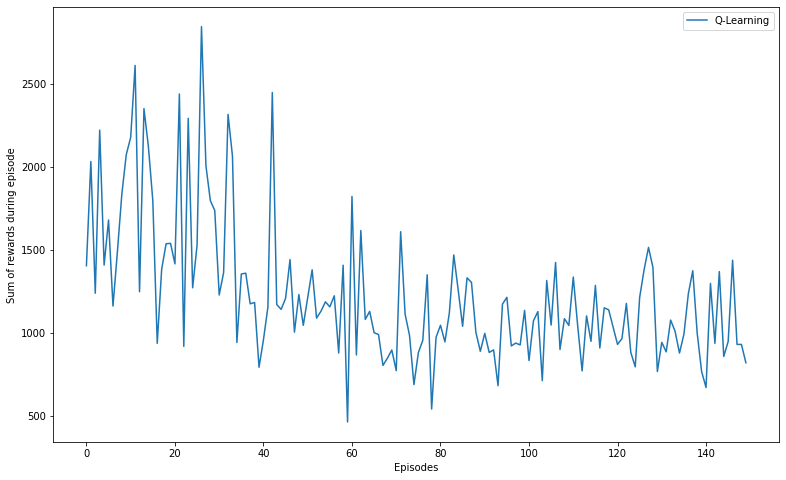

In [34]:
%matplotlib inline
plt.figure(figsize=(13,8))
plt.plot(rewards_q_learning, label='Q-Learning')
#plt.plot(rewards_sarsa, label='SARSA')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.legend();

In [578]:
memory_size = 3000
episodes = 100

# Warming up the agent
for _ in range(memory_size):
        action = agent._act(state, eps=1, q_value=1, neural_network = True)
        next_state, reward, done = environment.step(action)
        agent.observe(state, action, reward, next_state, done, warming_up=True)
        
rews = []
losses = []
epsilons = []
# Training the agent
for ep in range(episodes):
    state = environment.reset()
    rew = 0
    for _ in range(episode_length):
        action = agent.act(state, eps=1, q_value=1)
        
        for position in environment._positions:
            if all(str(environment._position==environment._positions[position])):
                position_name = position
        
    
        for _action in environment._actions:
            if all(str(action==environment._actions[_action])):
                action_name = _action
        
        next_state, reward, done = environment.step(action)
        
        for position in environment._positions:
            if all(str(environment._position==environment._positions[position])):
                next_position_name = position
        
        
           
        #print position_name, action_name, next_position_name
        loss = agent.observe(state, action, reward, next_state, done)
        state = next_state
        rew += reward
    print("Ep:" + str(ep)
           + "| rew:" + str(round(rew, 2))
           + "| eps:" + str(round(agent.epsilon, 2))
           + "| loss:" + str(round(loss.history["loss"][0], 4)))
    rews.append(rew)
    epsilons.append(agent.epsilon)
    losses.append(loss.history["loss"][0])

state:  [0, 3, 72.45, 72.5, None, 13930.0, 26180.0, 690.1311249137336, 689.6551724137931, 434058.7999999997, 7812.394252766129]
64
2
action[0]:  [ 0  2  4  8 13 18 20 31 32 37 38 41 44 47 51 52 54 56 58 63]
action[1]:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
q_target:  [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
reward:  [nan -120016.421875 -136536.78125 nan nan -73765.125 -81187.8828125 nan
 -83846.5 nan -175560.125 -220222.9375 -70941.4765625 -116273.0
 -209879.6875 nan -177838.53125 -58041.65234375 nan nan nan nan nan
 -231977.46875 -88996.0078125 -185769.0 nan -117532.953125 -165850.6875
 -128699.5546875 nan -130046.609375 -143855.546875 nan -214361.125
 -208286.25 -131697.84375 nan -210245.21875 -210048.15625 -200518.5625
 -175504.5 -183673.65625 nan -90447.1796875 -184747.71875 -178576.3125
 -212329.734375 nan -177432.25 -105982.59375 nan nan -205308.984375
 -128298.0703125 nan nan nan -78827.875 nan -86351.8125 -193882.890625
 -204475.781

ValueError: shape mismatch: value array of shape (64,) could not be broadcast to indexing result of shape (20,)

In [570]:
# Running the agent
done = False
state = environment.reset()
while not done:
    action = agent.act(state, 1, 1)
    
    for position in environment._positions:
          if all(str(environment._position==environment._positions[position])):
            position_name = position
        
    for _action in environment._actions:
          if all(str(action==environment._actions[_action])):
            action_name = _action
    
    state, _, done = environment.step(action)
    
    for position in environment._positions:
          if all(str(environment._position==environment._positions[position])):
            next_position_name = position
               
    print(position_name, action_name, next_position_name)

short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold short
short hold sho

## Нужно проверить, работает ли САРСа и Q-learning, потому что я добавила везде done в environment.step

## В all добавила превращение була в строку, иначе ошибка, что не итерабельный

In [469]:
print(state)

(2, 4, {'bid': 72.45, 'ask': 72.5}, 72.45, 13930.0, 16720.0, 690.1311249137336, 689.6551724137931, 292050.9925093113, 9772.121451672821)
